In [ ]:
# Requirements
import Pkg
Pkg.add("Random")
Pkg.add("Distributions")
Pkg.add("JuMP")
Pkg.add("KNITRO")
Pkg.add("Plots")
Pkg.add("StatsPlots")

# Hydro unit commitment problem

## Introduction

Given a set of production units, the unit commitment problem consists in determining the status (on/off) of each unit at each period as well as the quantity of electricity to produce, in order to maximize the profit or satisfy demands while minimizing operational costs.

Here, we focus on hydropower generation.

The powerhouse contains a turbine and a generator. The water goes from the upstream reservoir to the downstream river through the penstock, passing by the powerhouse. The flow of water through the pales of a turbine generates electricity which is then transferred from the generator to its final destination through the long distance power lines. The water that passes through the penstock is used to generate power, but water could also be released from the reservoir directly to the downstream river. This water is said to be spilled, as it is not used for production, but rather to avoid an overflow
of the reservoir.

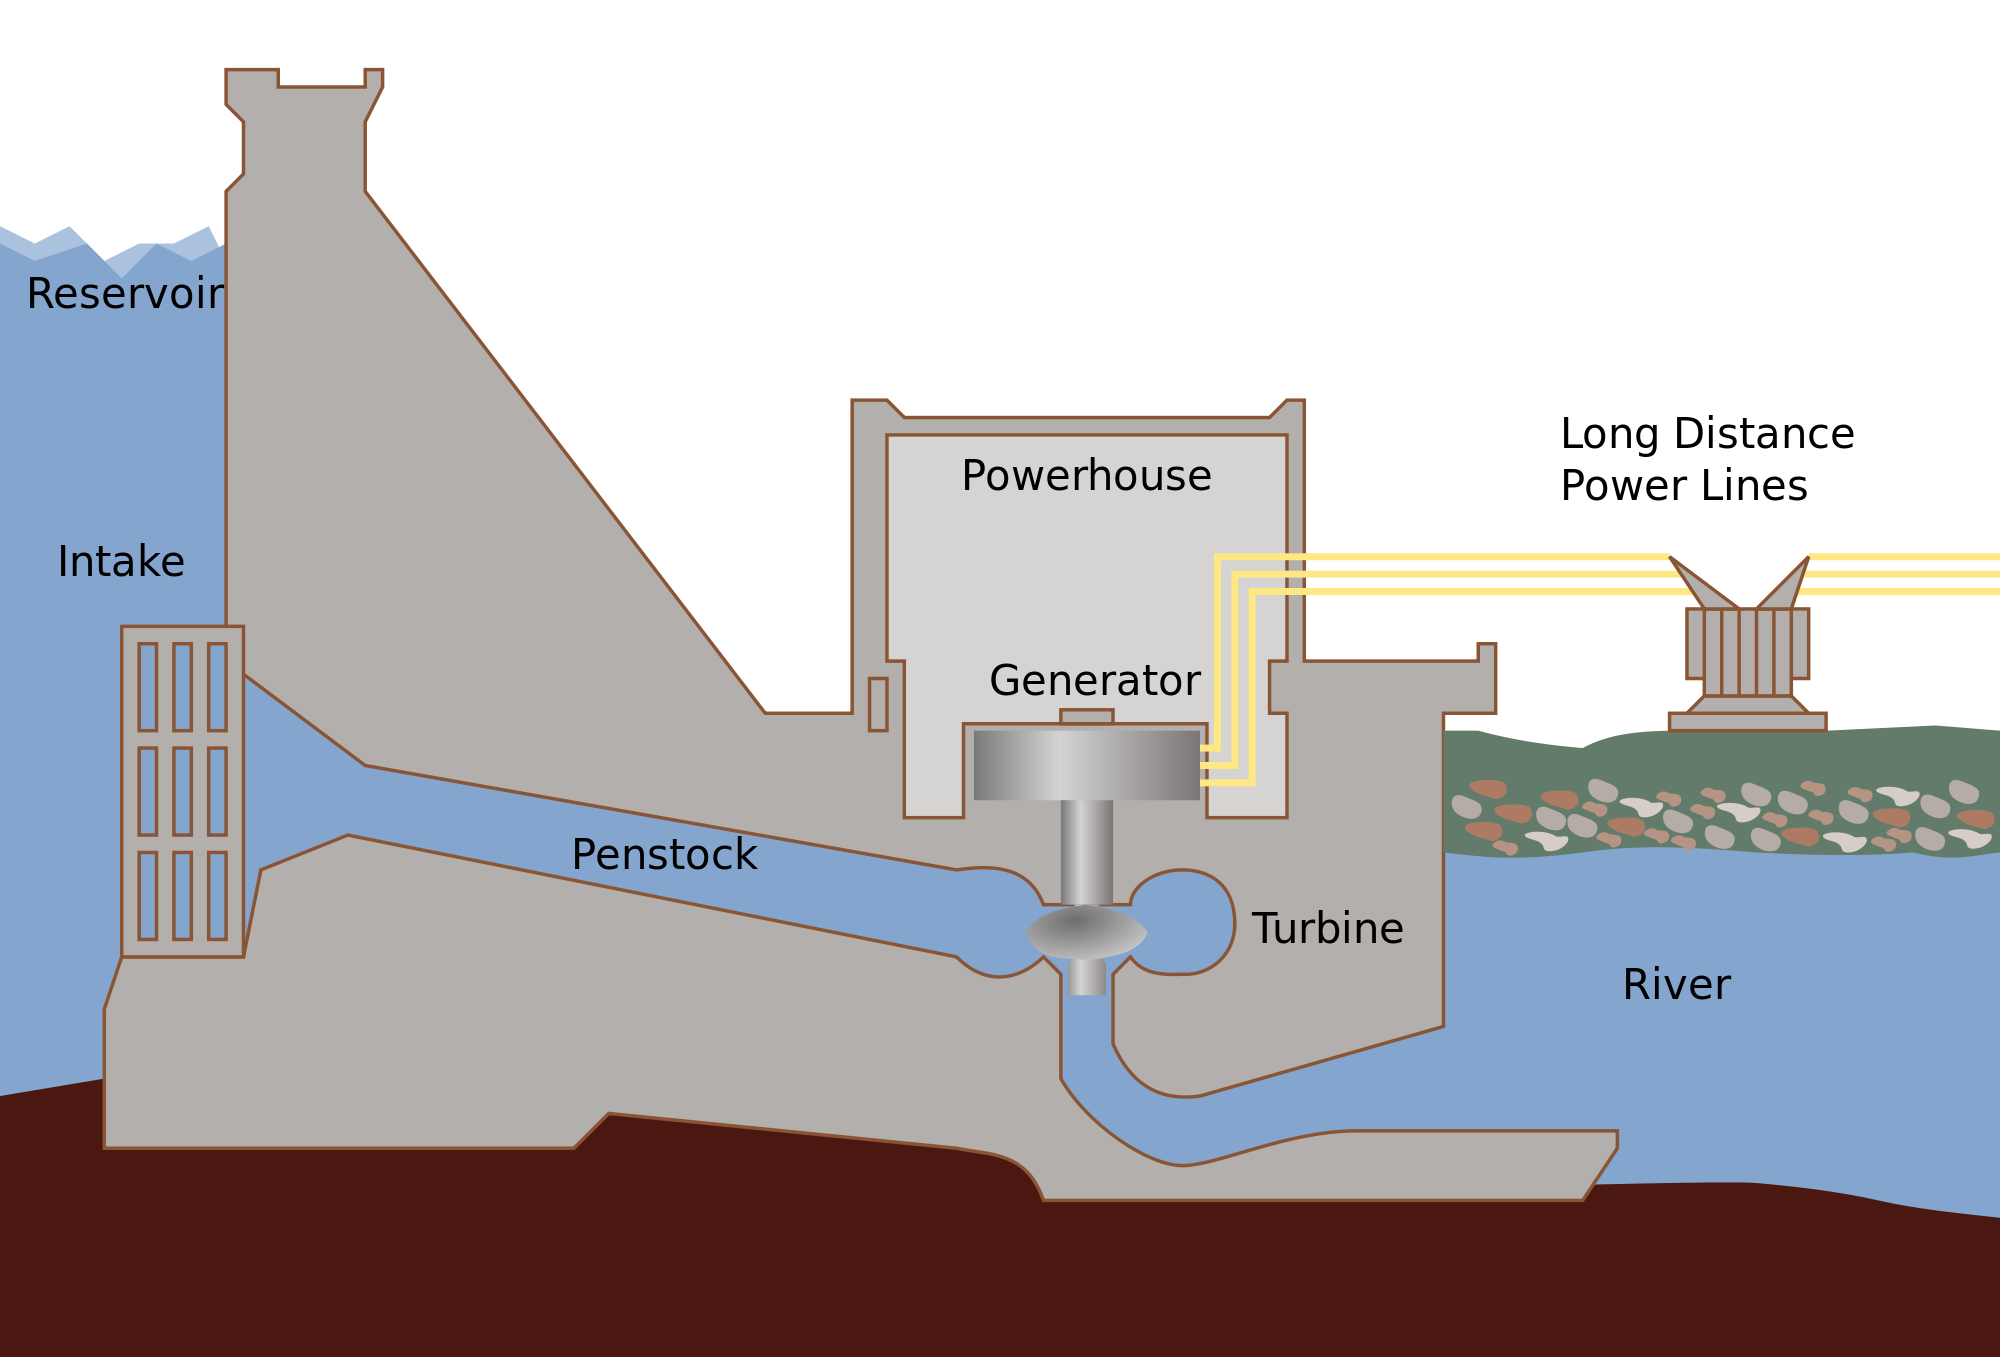
Image source: https://commons.wikimedia.org/wiki/File:Hydroelectric_dam-es.svg

The quantity of electricity $p_{j, t}$ produced by turbine $j$ at period $t$ is a nonlinear function of the net head $h^{net}_{t}$ and the water discharge $q_{j,t}$:

$$
		p_{j,t} = \eta_j \cdot q_{j,t} \cdot h^{net}_{t}
$$
where $\eta_j$ is called the efficiency of turbine $j$.

## Problem description

Here, we consider a problem composed of **several turbines and one reservoir**. The objective is to **maximize the revenue from selling generated power**.

**Input**:
* $H$ periods; for each period $t = 1, \dots, H$
  * a profit $R_t$ for selling a unit of electricty
  * an inflow $\Omega_t$
* $N$ turbines; for each turbine $i = 1, \dots, N$:
  * a minimum discharge $Q^\text{min}_j$
  * a maximum discharge $Q^\text{max}_j$
  * a minimum production $P^\text{min}_j$
  * a maximum production $P^\text{max}_j$
  * an efficiency $\eta_i$
* a minimum volume $V^\text{min}$ for the reservoir
* a maximum volume $V^\text{max}$ for the reservoir
* an initial volume $V^\text{init}$ for the reservoir
* a minimum final $V^\text{final}$ volume for the reservoir
* a function $F^\text{head}(v) = A^\text{head} v + B^\text{head}$ that returns the headwater depending on the volume in the reservoir
* a function $F^\text{tail}(q, s) = A^\text{tail}_q q + A^\text{tail}_s s + B^\text{tail}$ that returns the tailwater depending on the water discharge and the spilled water

**Problem**: find the quantity of water to send in each turbine at each period such that:
* The volume in the reservoir always stays in $[V^\text{min}, V^\text{max}]$
* The initial volume is equal to $V^\text{init}$
* The final volume is greater than $V^\text{final}$
* If a turbin is used
  * the water discharge in this turbine belongs to $[Q^\text{min}, Q^\text{max}]$; otherwise, it is null.
  * the production of this turbine belongs to $[P^\text{min}, P^\text{max}]$; otherwise, it is null.

**Objective**: maximize the profit

## Mixed-integer nonlinear program

**Variables**:

* $x_{j, t} \in \{ 0, 1 \}$, $j = 1, \dots, N$, $t = 1, \dots, H$: $x_{j, t} = 1$ iff turbine $j$ is on at period $t$, otherwise $0$.
* $q_{j, t} \in [0, Q_j^\text{max}]$, $j = 1, \dots, N$, $t = 1, \dots, H$: water discharge in turbine $j$ at period $t$.
* $q^\text{tot}_t \in \mathbb{R}$, $t = 1, \dots, H$: total water discharge at period $t$.
* $s_t \in \mathbb{R}^+$, $t = 1, \dots, H$: water spilled at period $t$.
* $p_{j, t} \in [0, P_j^\text{max}]$, $j = 1, \dots, N$, $t = 1, \dots, H$: production of turbine $j$ at period $t$
* $v_t \in [V^\text{min}, V^\text{max}]$: volume in the reservoir at period $t$
* $h^\text{head}_t \in \mathbb{R}$, $t = 1, \dots, N$: head water at period $t$
* $h^\text{tail}_t \in \mathbb{R}$, $t = 1, \dots, N$: tail water at period $t$
* $h^\text{net}_t \in \mathbb{R}$, $t = 1, \dots, N$: net head at period $t$

**Objective**: maximize the profit

$$ \max \sum_{t = 1}^H \sum_{j = 1}^N R_t p_{j, t} $$

**Constraints**:

* Initial and final volume:

$$ v_1 = V^\text{init} $$
$$ v_h \ge V^\text{final} $$

* Water balance: volume at $t$ = volume at $t - 1$ + inflow at $t$ - consumption at $t$

$$ \forall t = 2, \dots, H \qquad v_t = v_{t - 1} + 3600 \cdot \Omega_t - 3600 \cdot q^\text{tot}_t - 3600 \cdot s_t $$

* Water discharge limits

$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad q_{j, t} \ge Q_j^\text{min} x_{j, t} $$
$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad q_{j, t} \le Q_j^\text{max} x_{j, t} $$

* Production limits

$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad p_{j, t} \ge P_j^\text{min} x_{j, t} $$
$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad p_{j, t} \le P_j^\text{max} x_{j, t} $$

* Total water discharge

$$ \forall t = 1, \dots, H \qquad q_t^\text{tot} = \sum_{j = 1}^N q_{j, t} $$

* Headwater

$$ \forall t = 1, \dots, H \qquad h_t^\text{head} = A^\text{head} v_t + B^\text{head} $$

* Tailwater

$$ \forall t = 1, \dots, H \qquad h_t^\text{tail} = A^\text{tail}_q q^\text{tot}_t + A^\text{tail}_s s_t + B^\text{tail} $$

* Net head

$$ \forall t = 1, \dots, H \qquad h_t^\text{net} = h_t^{head} - h_t^{tail} $$

* Hydropower production function

$$ \forall j = 1, \dots, N \quad \forall t = 1, \dots, H \qquad p_{j, t} \le \eta_j \cdot q_{j,t} \cdot h^{net}_{t} $$

The model has the following properties:
* Continuous and binary variables
* Quadratic structures
* Non-convex
* Therefore, it is a non-convex MIQCQP

We solve the problem with Artelys Knitro using the [Pyomo](http://www.pyomo.org/) modeler.

## Input data

First, let's build some input data.

In [1]:
using Random, Distributions

struct Period
    profit::Float64
    inflow::Float64
end

struct Turbine
    efficiency::Float64
    minimum_discharge::Float64
    maximum_discharge::Float64
    minimum_production::Float64
    maximum_production::Float64
end

# Minimum and maximum volume in the reservoir
minimum_volume = 5e6
maximum_volume = 30e6
# Initial and final volume in the reservoir
initial_volume = 25e6
final_volume   = 25e6
# Coefficients of the headwater function
a_head = 1e-07
b_head = 50
# Coefficients of the tailwater function
a_tail_q = 0.005
a_tail_s = 0.001
b_tail = 30

# Number of turbines
N = 10
# Number of periods
H = 168

Random.seed!(N*H)

# Turbines
turbines = Array{Turbine}(undef, 0)
for j in 1:N
    # 0 <= minimum_production <= maximum_production <= 50
    minimum_production = rand(Uniform(0, 10))
    maximum_production = minimum_production + rand(Uniform(0,40))
    # 0 <= minimum_discharge <= maximum_discharge <= 100
    minimum_discharge = rand(TriangularDist(0, 100, 10))
    mode = max(minimum_discharge, 90)
    maximum_discharge = rand(TriangularDist(minimum_discharge, 100, mode))
    # 0.5 * rho_water * g <= efficiency <= 0.9 * rho_water * g
    efficiency = rand(Uniform(0.5, 0.9)) * 0.000001 * 1000 * 9.81
    
    turbine = Turbine(efficiency, minimum_discharge, maximum_discharge, minimum_production, maximum_production)
    push!(turbines, turbine)
end

# Periods
periods = Array{Period}(undef, 0)
for t in 1:H
    # 10 <= inflow <= 100
    inflow = rand(Uniform(10, 100)) * N
    # 10 <= profit <= 100
    ref = 40 * (1 + cos(t / 24 * 2 * π)) + 10
    profit = ref + rand(Uniform(-10, 10))
    
    period = Period(profit, inflow)
    push!(periods, period)
end

## JuMP model

Now, let's write the model with JuMP.

In [2]:
using KNITRO, JuMP

# Create a model
model = Model(KNITRO.Optimizer)

####################
# Create variables #
####################

# Variables x_{j, t}
@variable(model, x[j=1:N, t=1:H], Bin)

# Variables q_{j, t}
@variable(model, 0 <= q[j=1:N, t=1:H])

# Variables p_{j, t}
@variable(model, 0 <= p[j=1:N, t=1:H])

# Variables q_t
@variable(model, 0 <= qtot[t=1:H])

# Variables s_t
@variable(model, 0 <= s[t=1:H])

# Variables v_t
@variable(model, minimum_volume <= v[t=1:H] <= maximum_volume)

# Variables h^\text{head}_t.
@variable(model, h_head[t=1:H])

# Variables h^\text{tail}_t.
@variable(model, h_tail[t=1:H])

# Variables h^\text{net}_t.
@variable(model, 0 <= h_net[t=1:H])


#############
# Objective #
#############

@objective(model, Max, sum(periods[t].profit * p[j,t] for j in 1:N for t in 1:H))


###############
# Constraints #
###############

# Constraints: water balance
@constraint(model, water_balance_constraints[t=2:H], v[t] == v[t - 1] + 3600 * periods[t].inflow - 3600 * qtot[t] - 3600 * s[t])

# Constraints: minimum production
@constraint(model, minimum_production_constraints[j=1:N, t=1:H], p[j,t] >= turbines[j].minimum_production * x[j,t])

# Constraints: maximum production
@constraint(model, maximum_production_constraints[j=1:N, t=1:H], p[j,t] <= turbines[j].maximum_production * x[j,t])

# Constraints: minimum discharge
@constraint(model, minimum_discharge_constraints[j=1:N, t=1:H], q[j,t] >= turbines[j].minimum_discharge * x[j,t])

# Constraints: maximum discharge
@constraint(model, maximum_discharge_constraints[j=1:N, t=1:H], q[j,t] <= turbines[j].maximum_discharge * x[j,t])

# Constraints: total water discharge
@constraint(model, total_water_discharge_constraints[t=1:H], qtot[t] == sum(q[j, t] for j = 1:N))

# Constraints: headwater
@constraint(model, headwater_constraints[t=1:H], h_head[t] == a_head * v[t] + b_head)

# Constraints: tailwater
@constraint(model, tailwater_constraints[t=1:H], h_tail[t] == a_tail_q * qtot[t] + a_tail_s * s[t] + b_tail)

# Constraints: nethead
@constraint(model, nethead_constraints[t=1:H], h_net[t] == h_head[t] - h_tail[t])

# Constraints: hydropower production function
@constraint(model, hydropower_production_constraints[j=1:N, t=1:H], p[j,t] <= turbines[j].efficiency * q[j,t] * h_net[t])

# Constraint: initial conditions
@constraint(model, initial_volume_constraint, v[1] == initial_volume)
@constraint(model, final_volume_constraint, v[H] >= initial_volume)
@constraint(model, initial_spilled_water_constraint, s[1] == 0)
@constraint(model, initial_discharge_constraints[j=1:N], q[j, 1] == 0)


# Solve with Knitro.
#print(model)
#set_attribute(model, "mip_intvar_strategy", 1)
#set_attribute(model, "concurrent_evals", 0)
set_attribute(model, "mip_opt_gap_rel", 1)
set_attribute(model, "numthreads", 1)
JuMP.optimize!(model)


          Commercial License
         Artelys Knitro 14.0.0

No start point provided -- Knitro computing one.

datacheck:               0
hessian_no_f:            1
numthreads:              1
mip_opt_gap_rel:         1
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_rootalg from AUTO to 1.
Knitro changing mip_lpalg from AUTO to 3.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing mip_cut_probing from AUTO to 1.
Knitro changing mip_rounding from AUTO to 3.
Knitro changing mip_heuristic_strategy from AUTO to 1.
Knitro changing mip_heuristic_feaspump from AUTO to 1.
K

## Output visualization

Now let's plot the solution.

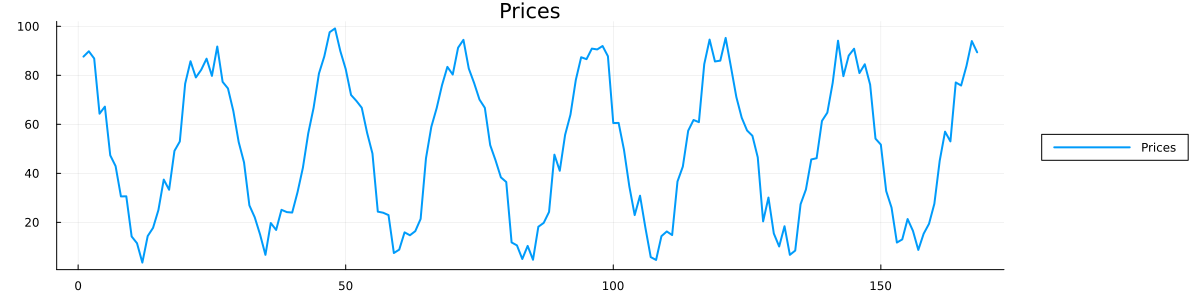

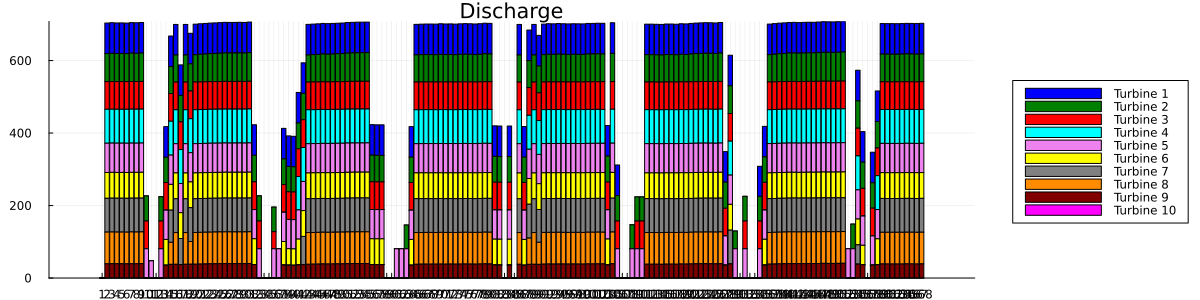

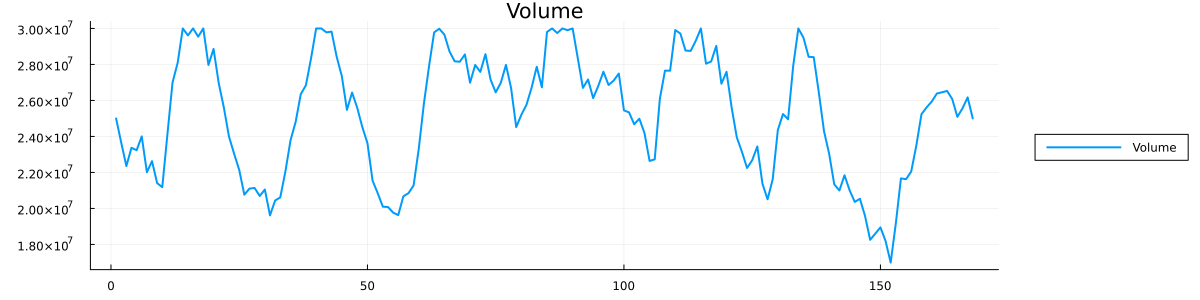

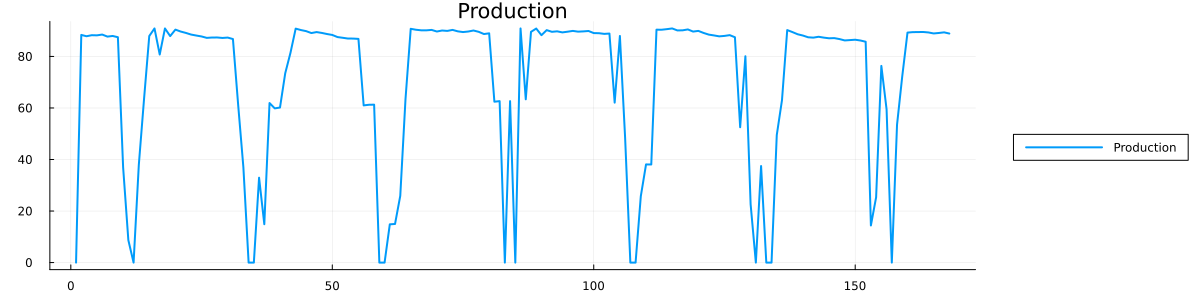

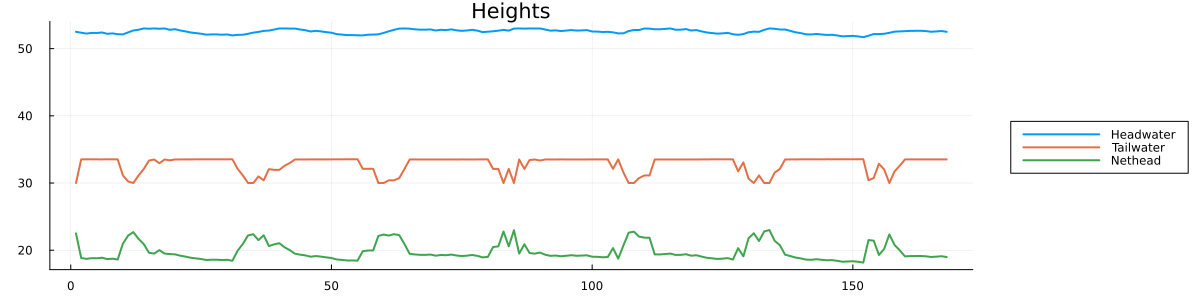

In [3]:
using Plots, StatsPlots

size = (1200,300)
indices = range(1, H, step=1)

# Plot prices
fig = plot(indices, [periods[t].profit for t in 1:H],
    title="Prices", label="Prices", xlabel="Periods", ylabel="Prices", linewidth=2, legend=:outerright, size=size)
display(fig)

# Plot solution, discharge for each turbine.
width = 0.9
colors = [:blue :green :red :cyan :violet :yellow :grey :darkorange :maroon :magenta :lightblue :lightcoral :bisque :slateblue]
turbine_data = [value(q[1,t]) for t in 1:H]
for j in 2:N
    new_row = [value(q[j,t]) for t in 1:H]
    turbine_data = hcat(turbine_data, new_row)
end
ticklabel = string.(collect(1:H))
fig = groupedbar(turbine_data,
    bar_position = :stack, bar_width=0.9, xticks=(1:H, ticklabel),
    title="Discharge", label=reshape(["Turbine $j" for j in 1:N],(1,:)), color=colors, legend=:outerright, size=size)
display(fig)

# Plot reservoir volume
fig = plot(indices, [value(v[t]) for t in 1:H],
    title="Volume", label="Volume", xlabel="Periods", ylabel="Volume", linewidth=2, legend=:outerright, size=size)
display(fig)

# Plot production
fig = plot(indices, [sum(value(p[j,t]) for j in 1:N) for t in 1:H],
    title="Production", label="Production", xlabel="Periods", ylabel="Production", linewidth=2, legend=:outerright, size=size)
display(fig)

# Plot headwater, tailwater and net head
headwater = [value(h_head[t]) for t in 1:H]
tailwater = [value(h_tail[t]) for t in 1:H]
nethead   = [value(h_net[t])  for t in 1:H]
label = ["Headwater" "Tailwater" "Nethead"]
fig = plot(indices, [headwater, tailwater, nethead],
    title="Heights", label=label, xlabel="Periods", ylabel="Height", linewidth=2, legend=:outerright, size=size)
display(fig)